# Questions

#### Identify trends and key indicators of the real estate rental market in Switzerland.
 + Identify market leaders 
 + Create a view of housing prices by canton
 + Identify geographic trends 

# Preparation
### Collecting data with web-scraping

In [340]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import sqlite3

# Creating a base path.
url = "https://www.tutti.ch/de/q/immobilien-apartment-house-rent/Ak8CqcmVhbEVzdGF0ZZSSkqtsaXN0aW5nVHlwZZKpYXBhcnRtZW50pWhvdXNlkqlwcmljZVR5cGWkUkVOVMDAwA?sorting=newest&page="
# Configuring the database.
con = sqlite3.connect('tutti.db')
cur = con.cursor()
cur.execute('''CREATE TABLE IF NOT EXISTS real_estate ( ID INTEGER PRIMARY KEY AUTOINCREMENT, author text, name text, type text, price real, period text, rooms real, zip integer)''')

# Launching the page through the browser.
driver = webdriver.Chrome()
driver.get(url+"1")
# Imitation of click on the cookie accept button.
WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.ID, 'onetrust-accept-btn-handler'))).click()
# Getting the number of the last page.
maxi_page = max(map(lambda item: int(item.text), driver.find_elements(By.XPATH, "//*[contains(@aria-label, 'Go to page')]")))

for i in range(1, maxi_page):
    driver.get(f'{url}{i}')
    # Getting the posts links.
    property_listings = list(map(lambda item: item.get_attribute("href"), driver.find_elements(By.CLASS_NAME, 'css-lu7t05')))
    
    for item in property_listings:
        driver.get(item)
        # Getting the required fields.
        author_name = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.TAG_NAME, 'h4'))).text    
        post_name = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.TAG_NAME, 'h1'))).text
        content = driver.find_element(By.XPATH, "//*[contains(text(), 'Typ')]/../../../../..").text.splitlines()
        # Adding to the database.
        try:
            cur.execute("INSERT INTO real_estate (author, name, type, price, period, rooms, zip) VALUES(?, ?, ?, ?, ?, ?, ?)",
                                                  (author_name, 
                                                   post_name, 
                                                   content[content.index('Typ')+1], 
                                                   float(''.join(filter(str.isdigit, content[content.index('Miete CHF')+1]))), 
                                                   content[content.index('Miete CHF')+1].split(' ')[-1], 
                                                   float(content[content.index('Zimmer')+1]), 
                                                   int(content[content.index('PLZ')+1])))

            con.commit()
        except:
            continue
        
driver.quit()


# Data cleaning

In [101]:
import sqlite3
import pandas as pd
import numpy as np

#Initialization of database
con = sqlite3.connect('tutti.db')
cur = con.cursor()
cur.execute('''CREATE TABLE IF NOT EXISTS real_estate ( ID INTEGER PRIMARY KEY AUTOINCREMENT, author text, name text, type text, price real, period text, rooms real, zip integer)''')


sql_query = pd.read_sql_query ('''
                               SELECT
                               *
                               FROM real_estate
                               ''', con)

df = pd.DataFrame(sql_query, columns = ['author', 'name', 'type', 'price', 'period', 'rooms', 'zip'])

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3372 entries, 0 to 3371
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   author  3372 non-null   object 
 1   name    3372 non-null   object 
 2   type    3372 non-null   object 
 3   price   3372 non-null   float64
 4   period  3372 non-null   object 
 5   rooms   3372 non-null   float64
 6   zip     3372 non-null   int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 184.5+ KB


In [103]:
df.describe()

,price,rooms,zip
count,3372.000000,3372.000000,3372.000000
mean,1739.468268,3.266607,5451.336002
std,1249.559740,1.252919,2522.178750
min,390.000000,1.000000,1000.000000
25%,1173.750000,2.500000,3110.000000
50%,1480.000000,3.500000,6500.000000
75%,1950.000000,4.000000,6963.000000
max,20000.000000,12.500000,9656.000000


In [104]:
df['type'].unique()

array(['Mietangebote'], dtype=object)

In [120]:
df = df.drop('type', axis=1)

In [105]:
df['period'].unique()

array(['Monat'], dtype=object)

In [121]:
df = df.drop('period', axis=1)

In [122]:
df[df.duplicated()]

,author,name,price,rooms,zip


In [123]:
df.drop_duplicates()

,author,name,price,rooms,zip
0,The Agency brend of Domo Mea Real Estate sagl,"AMPIO E LUMINOSO 3,5 LOCALI CON VISTA MONTI",1150.0,3.5,6833
1,Luana,Appartamento 2.5 locali a Cassarate a due pass...,1400.0,2.5,6900
2,Studio contabile Rodoni Sagl,Duplex di 4.5 locali - Cugnasco,1700.0,4.5,6597
3,Studio contabile Rodoni Sagl,3.5 locali a Bellinzona,1500.0,3.5,6500
4,angelo.dona1,Pambio-Noranco 3.5 con bellissima terrazza nel...,1290.0,3.5,6915
...,...,...,...,...,...
2842,Mélanie,RM - Studio Standard,2100.0,1.0,1260
2843,Miranda Sopi,"Klein, aber oho",850.0,1.0,8280
2844,Aris,Appartamento Locarno 3 Locali,1350.0,3.0,6600
2845,Hermann M.,Einaufen gleich um die Ecke....,692.0,1.0,4057


In [124]:
con.execute('''DROP TABLE IF EXISTS real_estate_moded''')
df.drop_duplicates().to_sql('real_estate_moded', con)

2847

# Merging data 

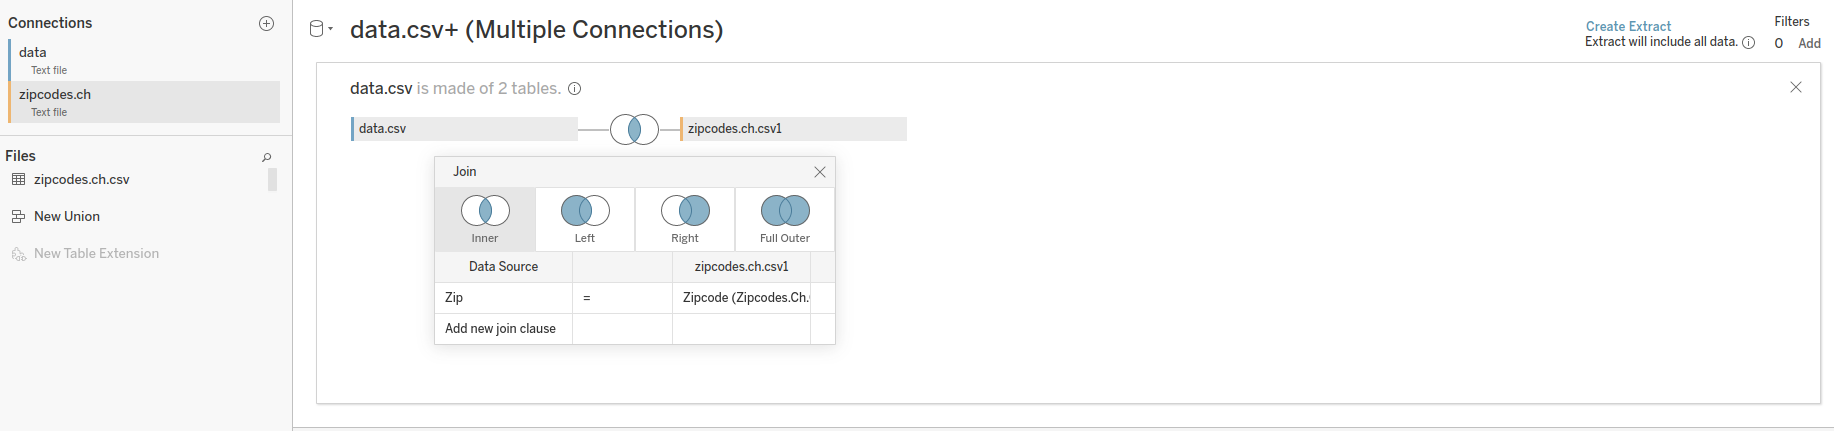

# Creating plot with seaborn

In [130]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [133]:
sql_query_m = pd.read_sql_query ('''
                               SELECT
                               *
                               FROM real_estate_moded
                               ''', con)

df = pd.DataFrame(sql_query_m, columns = ['author', 'name', 'price', 'rooms', 'zip'])

<AxesSubplot:xlabel='price', ylabel='rooms'>

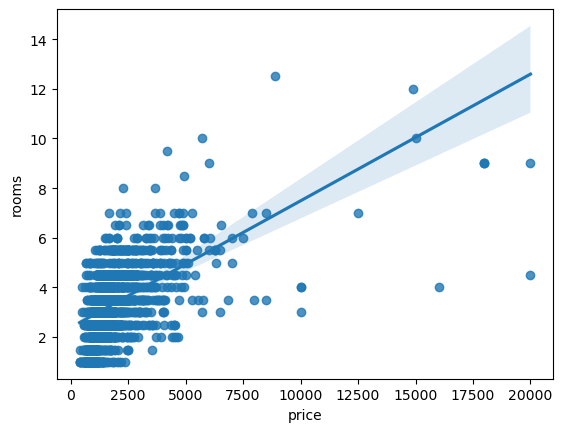

In [147]:
sns.regplot(
    data=df,
    x="price", y="rooms"
)

# Analizing & Creating dashboard with Tableau

#### Project link : https://public.tableau.com/views/RentalhousingmarketinSwitzerland/Map?:language=en-US&:display_count=n&:origin=viz_share_link


In [125]:
sql_query = pd.read_sql_query ('''
                               SELECT
                               *
                               FROM real_estate_moded
                               ''', con)

df = pd.DataFrame(sql_query, columns = ['author', 'name', 'price', 'rooms', 'zip'])

Creating of csv to use in Tableau 

In [126]:
file = open('data.csv', 'w')
file.write(df.to_csv())
file.close()

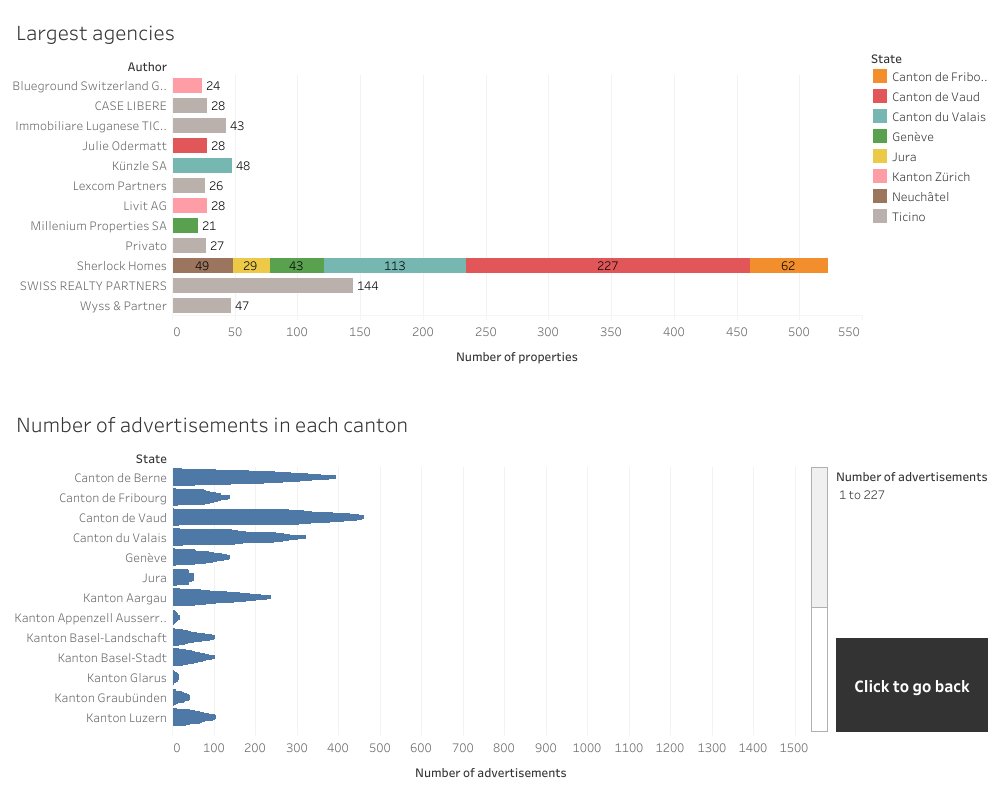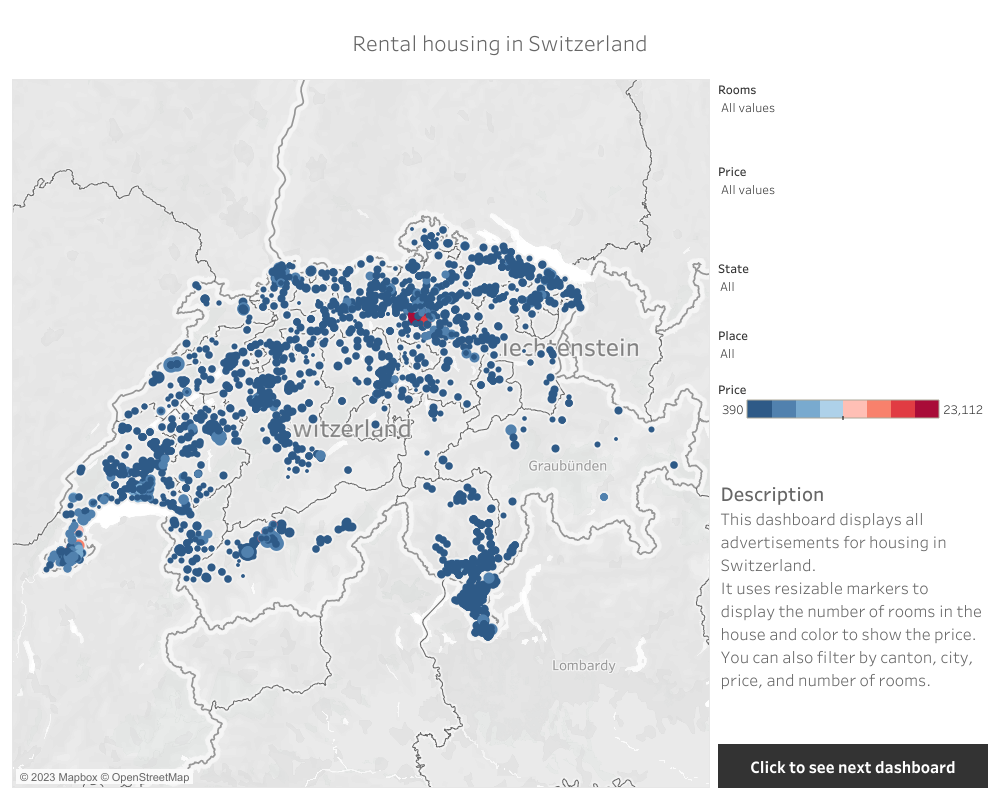
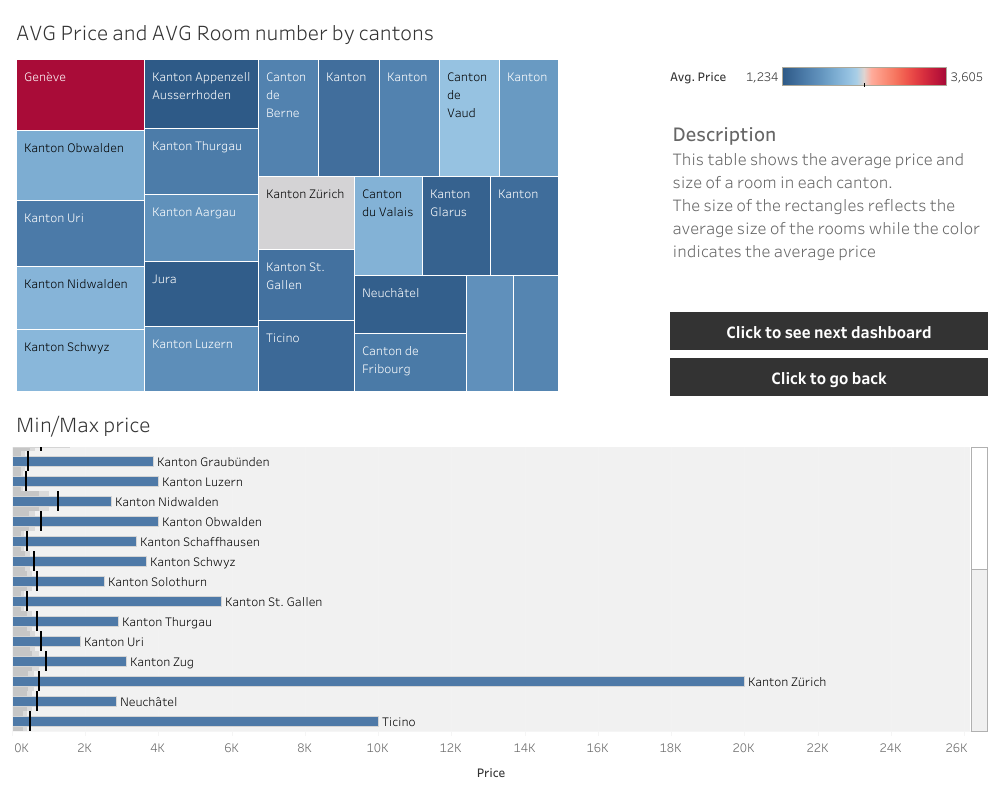
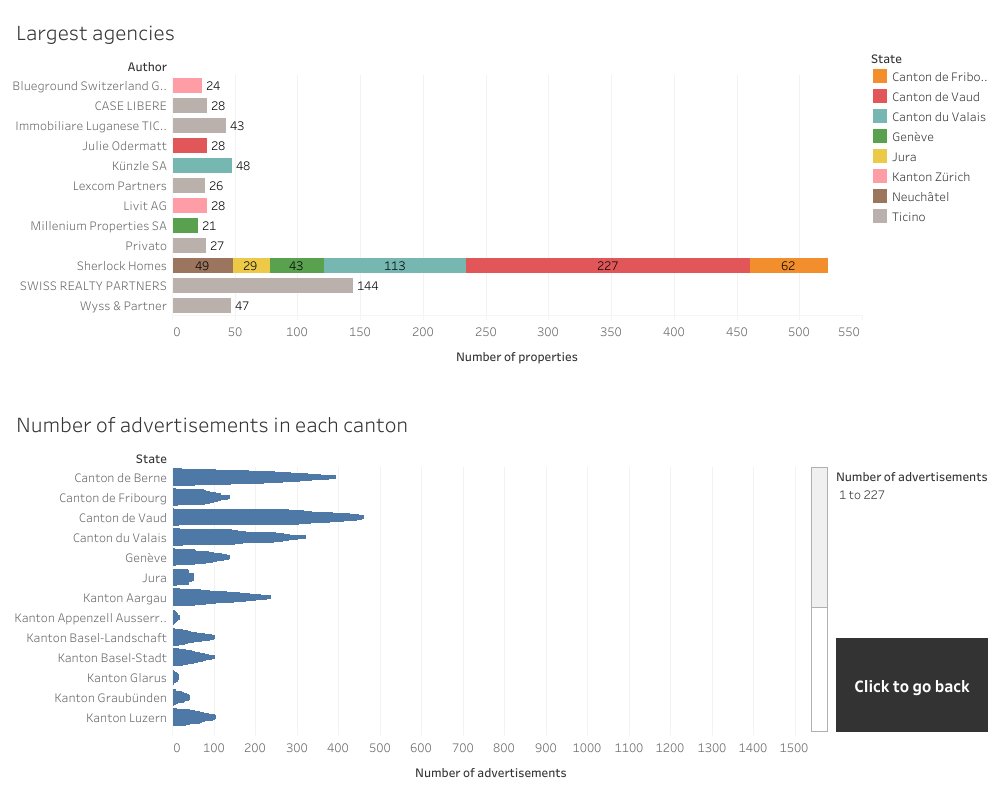


# Deprecated

In [93]:
postal_codes = {
    "Geneva": range(1201, 1299),
    "Zurich": range(8000, 8999),
    "Bern": range(3000, 3999),
    "Lausanne": range(1003, 1099),
    "Basel": range(4000, 4999),
    "Luzern": range(6003, 6099),
    "St. Gallen": range(9000, 9999),
    "Lucerne": range(6004, 6099),
    "Ticino": range(6500, 6999),
    "Vaud": range(1000, 1999),
    "Zürich": range(8000, 8999),
    "Neuchâtel": range(2000, 2999),
    "Nidwalden": range(6300, 6399),
    "Obwalden": range(6400, 6499),
    "Sankt Gallen": range(9000, 9999),
    "Schaffhausen": range(8200, 8299),
    "Schwyz": range(6430, 6439),
    "Solothurn": range(4500, 4999),
    "Thurgau": range(8500, 8599),
    "Turgi": range(5200, 5299),
    "Uri": range(6460, 6469),
    "Zürich": range(8000, 8999),
    "Valais": range(3900, 3999),
    "Vaud": range(1000, 1999),
    "Zug": range(6300, 6399),
    "Zürich": range(8000, 8999)
}

def get_canton_by_postal_code(postal_code):
    for canton, code_range in postal_codes.items():
        if postal_code in code_range:
            return canton
    return 'Other'

In [97]:
cantonsCol = []

for index, row in df.iterrows():
    cantonsCol.append(get_canton_by_postal_code(row['zip']))

df['canton'] = cantonsCol

In [99]:
df['zip'].loc[df['canton'] == 'Other'].unique()

array([7031, 5704, 5028, 7142, 5012, 5412, 5745, 5430, 7189, 5453, 5506,
       6265, 5605, 5054, 5400, 5504, 7302, 5432, 5630, 6275, 5600, 6106,
       6170, 7188, 6232, 7412, 6285, 5000, 6206, 6105, 5080, 6130, 5033,
       5027, 5502, 7000, 7205, 5034, 5064, 5300, 6102, 6231, 5727, 7317,
       5082, 5442, 5014, 5742, 7130, 5022, 6203, 5452, 5037, 6252, 7310,
       5606, 5035, 5105, 5102, 7260, 5436, 5728, 5324, 6215, 6204, 5524,
       5330, 5737, 5013, 5107, 5620, 5464, 5326, 6264, 6280, 5612, 7017,
       5734, 6208, 7532, 5103, 7500, 5726, 7277, 5312, 7012, 5415, 7545,
       7252, 5304, 5703, 6242, 5024, 7320, 5423, 5610, 5032, 5070, 5408,
       5303])